In [659]:
import numpy as np
import pyxdf
import matplotlib.pyplot as plt
from scipy import signal, fftpack
from scipy.signal import hilbert, butter, filtfilt

import mne 
from mne.time_frequency import psd_welch

## check no-TACS data 

In [660]:
## import no-tacs data

data, header=  pyxdf.load_xdf('../recordings/P01-with-tacs-R1.xdf')

if data[0]['info']['name'][0] == 'ExperimentMarkers': 
    markers_data = data[0] 
    opm_data = data[1]
else: 
    markers_data = data[1]   
    opm_data = data[0]

fs = 1000 # sampling rate 

opm_time_stamps = opm_data['time_stamps'] 


# plt.figure(figsize=(15,10))
# plt.plot(markers_data['time_stamps'][:40], markers_data['time_series'][:40])



found likely XDF file corruption (unpack requires a buffer of 8 bytes), scanning forward to next boundary chunk.


In [661]:
## set up the markers information
marker_id_start = 7
marker_id_end = 9
marker_id_blink_on = 2
marker_id_blink_off = 1

markers_data_ts = markers_data['time_stamps']

# get the approximate index in chassis time stamp for start trigger
start_marker = markers_data_ts[np.where(markers_data['time_series'].flatten() == marker_id_start)[0]][0]
diff = start_marker - opm_time_stamps 
diff_bool = (diff < 0.001) & (diff > 0) 
start_marker_index = np.where(opm_time_stamps == opm_time_stamps[diff_bool])[0][0]

# get the approximate index in chassis time stamp for end trigger
end_marker = markers_data_ts[np.where(markers_data['time_series'].flatten() == marker_id_end)[0]][0]
diff = end_marker - opm_time_stamps 
diff_bool = (diff < 0.001) & (diff > 0) 
end_marker_index = np.where(opm_time_stamps == opm_time_stamps[diff_bool])[0][0]
num_trials = int((markers_data['time_series'].flatten().shape[0] - 2)/20)

#make epochs time stamps
markers_data_cut = markers_data['time_series'].flatten()[1:-1] # remove start and end marker 

epochs_ts = np.zeros(shape=[num_trials]) # for start markers only, then we can add the 2seconds for end trial

index = 1
index_1 = 0 #for feeding epochs_ts


for i in markers_data_cut: 
    if index % 20 == 1: # there are 20 markers within a trial. 10hz for 2 seconds
        epochs_ts[index_1] = markers_data_ts[index]
        index_1 += 1
    index +=1


epochs_ts_index = np.zeros_like(epochs_ts, dtype=int)
for i, ts in enumerate(epochs_ts): 
    diff = ts - opm_time_stamps 
    diff_bool = (diff < 0.001) & (diff > 0) 
    epochs_ts_index[i] = np.where(opm_time_stamps == opm_time_stamps[diff_bool])[0][0]




In [662]:
## setting up the raw time series data for processing 

adc_diode_idx = 0
# adc_tacs_idx = 11
## There will be _full and _cut, the difference is in the duration cut.
opm_data_full = opm_data['time_series'][:] * 1e-15 #in tesla

adc_diode_full = opm_data_full[:, adc_diode_idx]
# adc_tacs_full = opm_data_full[:, adc_tacs_idx]

# opm_data_full = np.delete(opm_data_full, adc_tacs_idx, 1)
opm_data_full = np.delete(opm_data_full, adc_diode_idx, 1)

num_channels_w_adcs = opm_data['time_series'][:].shape[1]
num_samples = opm_data_full.shape[0]

# start = start_marker_index # seconds in 
# end = end_marker_index #seocnds before it ends

# opm_data_cut = opm_data_full[start:end]
# adc_diode_cut = adc_diode_full[start:end]
# adc_tacs_cut = adc_tacs_full[start:end]

# print("Time left in cut raw: %f s" %(opm_data_cut.shape[0]/fs))

# channel names according to the order of the OPM data without the ADCs
channel_names = np.zeros(shape=[num_channels_w_adcs], dtype='object') 
channel_types = np.zeros(shape=[num_channels_w_adcs], dtype='object')
channel_units = np.zeros(shape=[num_channels_w_adcs], dtype='object')
for i, channel in enumerate(opm_data['info']['desc'][0]['channels'][0]['channel']):
    # print(channel)
    channel_names[i] = channel['label'][0]
    channel_types[i] = channel['type'][0]
    channel_units[i] = channel['unit'][0]

# channel_names = np.delete(channel_names, adc_tacs_idx)
channel_names = np.delete(channel_names, adc_diode_idx)

# channel_types = np.delete(channel_types, adc_tacs_idx)
channel_types = np.delete(channel_types, adc_diode_idx)


## channels ordering
ref_channels = ['01:01:50', '01:02:50', '01:05:50']

tACS_channel = ['01:00:0']

channel_orders = ['00:12:50','00:08:50', '01:04:50'
, '00:11:50', '00:07:50', '01:03:50'
, '00:10:50', '00:06:50', '00:03:50'
, '00:09:50', '00:05:50', '00:01:50']


## create full time-series of the adc_diode

# checking the flicker timing recorded by the photodiode on the projector
threshold = min(adc_diode_full) + (max(adc_diode_full) - min(adc_diode_full)) * 0.8

# plt.plot(adc_diode_full[11000:20000])

adc_diode_square = np.where(adc_diode_full > threshold, 1, 0) #square signal
adc_diode_markers = np.where(adc_diode_full > threshold, 1, 0) # vertical lines


on = False
for idx, x in enumerate(adc_diode_square): 
    if x==1 and not on: ## if this is the first one
        on = True
    elif x==1 and on: ## during the on period.
        adc_diode_square[idx] = 1
        adc_diode_markers[idx] = 0
        if idx+1==adc_diode_square.shape[0] or adc_diode_square[idx+1] == 0: ## if this is the last one
            adc_diode_square[idx] = 0
            adc_diode_markers[idx] = 1
            on = False

# get the timing on between flickers. It should be 0.1 s interval (10hz flicker) + random ITI 
index_diode_on = np.where(adc_diode_markers == 1)[0] 
timing_diode = np.diff(opm_time_stamps[index_diode_on])

## create a phase time series of the ADC diode (visual stimuli)
adc_diode_phase = np.angle(hilbert(adc_diode_square), deg=False)



# plt.plot(adc_diode_square[12000:18000])

In [663]:
##make epochs for OPM data and 

trial_dur = 2000 #2 seconds trial

#make mne object, maybe for easier filtering or other pre-processing stuff..
info = mne.create_info(list(channel_names), fs, list(channel_types))
raw = mne.io.RawArray(opm_data_full[:].T, info)
raw.drop_channels(ref_channels)
#get the tACS mne raw data
raw_tacs = raw.copy().pick_channels(tACS_channel)
# raw will only be left with primary channels only
raw.drop_channels(tACS_channel)
raw.reorder_channels(channel_orders)

raw_fil_10 = raw.copy().filter(4,6)
raw_fil_1_30 = raw.copy().filter(1,30)


raw_arr_f10 = raw_fil_10[:][0]
raw_arr_f1_30 = raw_fil_1_30[:][0]
print(raw_arr_f1_30.shape)

num_primary_channels = raw_arr_f10.shape[0] # exlcuding reference and adc
epo_opm_f10 = np.zeros(shape=[num_primary_channels, num_trials, trial_dur]) #filtered 10hz
epo_opm_f1_30 = np.zeros(shape=[num_primary_channels, num_trials, trial_dur]) #filtered 10hz

epo_diode_phase = np.zeros(shape=[num_trials, trial_dur]) 

for i, ts_index in enumerate(epochs_ts_index): 
    # print(raw_arr[:, ts_index:ts_index+trial_dur].shape)
    # print(ts_index)
    start = ts_index
    end = ts_index+trial_dur

    epo_opm_f10[:, i, :] = raw_arr_f10[:, start:end]
    epo_opm_f1_30[:, i, :] = raw_arr_f1_30[:, start:end]

    epo_diode_phase[i,:] = adc_diode_phase[start:end]


Creating RawArray with float64 data, n_channels=16, n_times=105005
    Range : 0 ... 105004 =      0.000 ...   105.004 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 19 - 21 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 19.00
- Lower transition bandwidth: 4.75 Hz (-6 dB cutoff frequency: 16.62 Hz)
- Upper passband edge: 21.00 Hz
- Upper transition bandwidth: 5.25 Hz (-6 dB cutoff frequency: 23.62 Hz)
- Filter length: 695 samples (0.695 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband a

11.29
67.151
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)


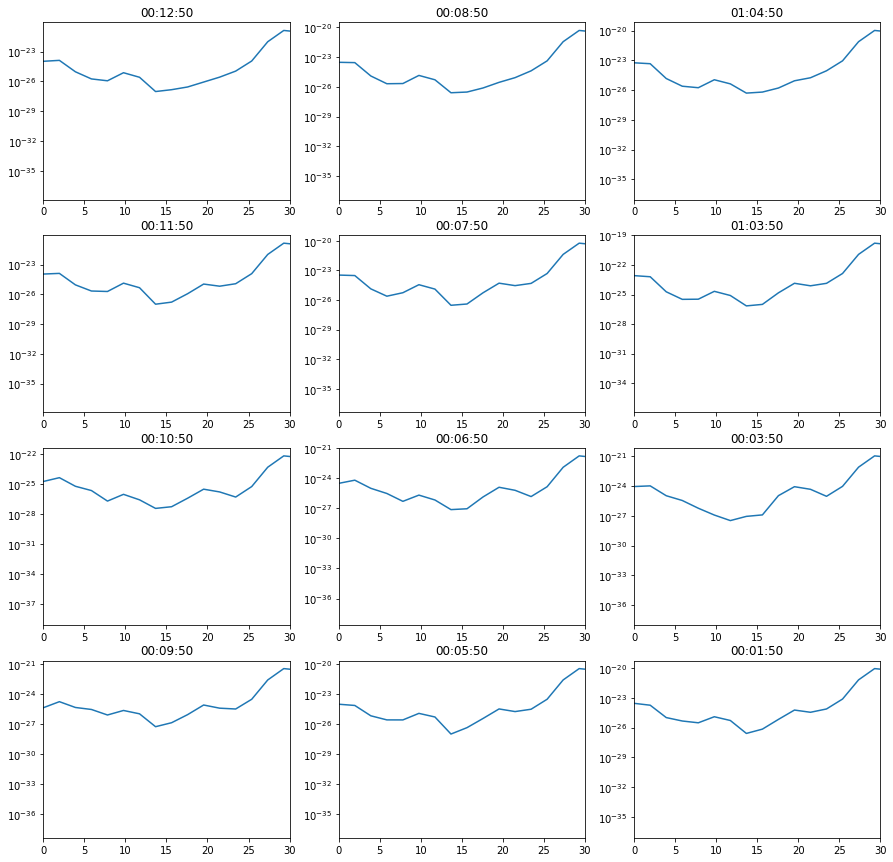

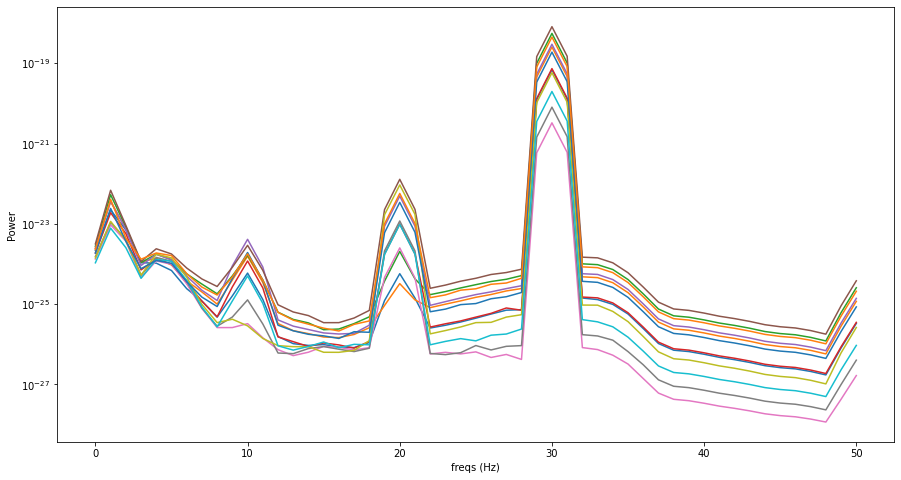

In [664]:
epo_mean = np.mean(epo_opm_f1_30, axis=1)

# # plot psd OPM data per channel
plt.figure(figsize=(15,15))
for i in range(num_primary_channels):

    f, pxx = signal.welch(epo_mean[i], fs, nperseg=512)
    plt.subplot(4,3,i+1)
    plt.title(channel_orders[i])
    plt.semilogy(f, pxx)
    plt.xlim(0,30)

    # pxx, f = psd_welch(raw, fmax=100, n_fft=1000, picks=channel_orders[i])
    # plt.semilogy(f, pxx.flatten())
    # plt.xlabel("freqs (Hz)")
    # plt.ylabel("Power")

# %matplotlib inline
plt.figure(figsize=(15,8))
tmin = start_marker_index/fs
tmax = end_marker_index/fs
print(tmin)
print(tmax)
for i in range(num_primary_channels):
    pxx, f = psd_welch(raw_fil_1_30, fmax=50, n_fft=1000, picks=channel_orders[i], tmin=tmin, tmax=tmax)
    plt.semilogy(f, pxx.flatten())
    plt.xlabel("freqs (Hz)")
    plt.ylabel("Power")


In [665]:
# ## see the flickers with the OPM data
# %matplotlib inline

# plt.plot(time_stamps[650:1650], opm_data_cut[650:1650,0])
# for i in index_diode_on[:10]:
#     plt.axvline(x=time_stamps[i], color='red')

# ## make a time-series of the visual stimulus

    

## Some analysis

In [666]:
# ## prepare OPM data struct

# %matplotlib qt
# info = mne.create_info(list(channel_names), fs, list(channel_types))
# raw = mne.io.RawArray(opm_data_cut[:].T, info)

# ## plot/check reference data
# # ref_data = raw.pick_channels(ref_channels)[:][0]
# # print(ref_data.shape)
# # plt.plot(ref_data[0,:5000])
# # plt.plot(ref_data[1,:5000])
# # plt.plot(ref_data[2,:5000])


# ## Plot PSD of primary channels

# raw.drop_channels(ref_channels)
# raw.reorder_channels(channel_orders)

# # raw.filter(9,12)
# # raw.plot_psd(fmax=30)

# # plot psd OPM data per channel
# for i in range(len(channel_orders)):
#     pxx, f = psd_welch(raw, fmax=100, n_fft=1000, picks=channel_orders[i])
#     plt.subplot(4,3,i+1)
#     plt.semilogy(f, pxx.flatten())
#     plt.title(channel_orders[i])
#     plt.xlabel("freqs (Hz)")
#     plt.ylabel("Power")



(12, 55861)


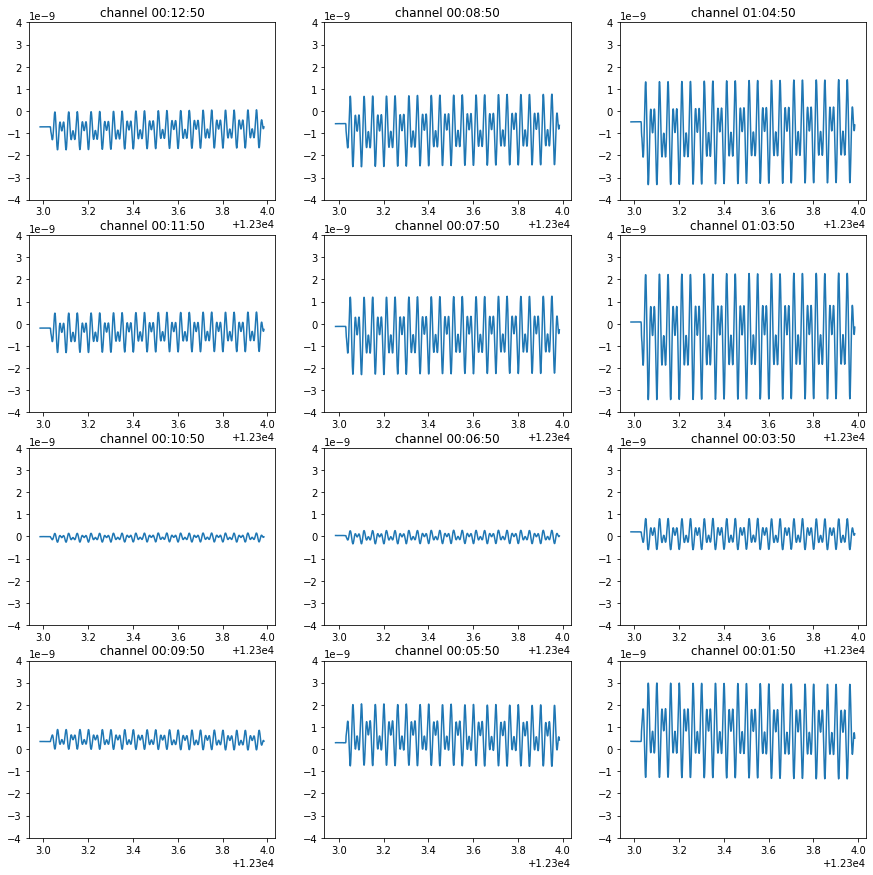

In [667]:
%matplotlib inline
# ## Plot time-series primary channels

# raw.filter(9,11)
raw_arr = raw[:][0][:, start_marker_index:end_marker_index]
print(raw_arr.shape)

start = 0
end = 1000

markers_line = adc_diode_markers[start:end].astype(bool)
marker_ts = opm_time_stamps[start:end][markers_line]

# Visualize raw data with markers timestamps

plt.figure(figsize=(15,15))
for i in range(raw_arr.shape[0]): 
    plt.subplot(4,3,i+1)
    plt.title('channel ' + raw.ch_names[i])
    plt.plot(opm_time_stamps[start:end], raw_arr[i, start:end])
    plt.ylim((-4e-9,4e-9))

    adc_diode_markers
    for ts in marker_ts:
        # print(time_stamps[j])
        plt.axvline(x=ts, c="red")





## Analyze phase information of visual stimuli and OPM data

PLV for channel 9 in all epochs:  [0.08930486 0.06322898 0.05665951 0.02576437 0.03416335 0.06013714
 0.01841397 0.02020189 0.03888774 0.02913875 0.02414189 0.03362126
 0.01242981 0.02869546 0.0143571  0.02241954 0.0488375  0.03941223
 0.0484659  0.06197576 0.07205602]


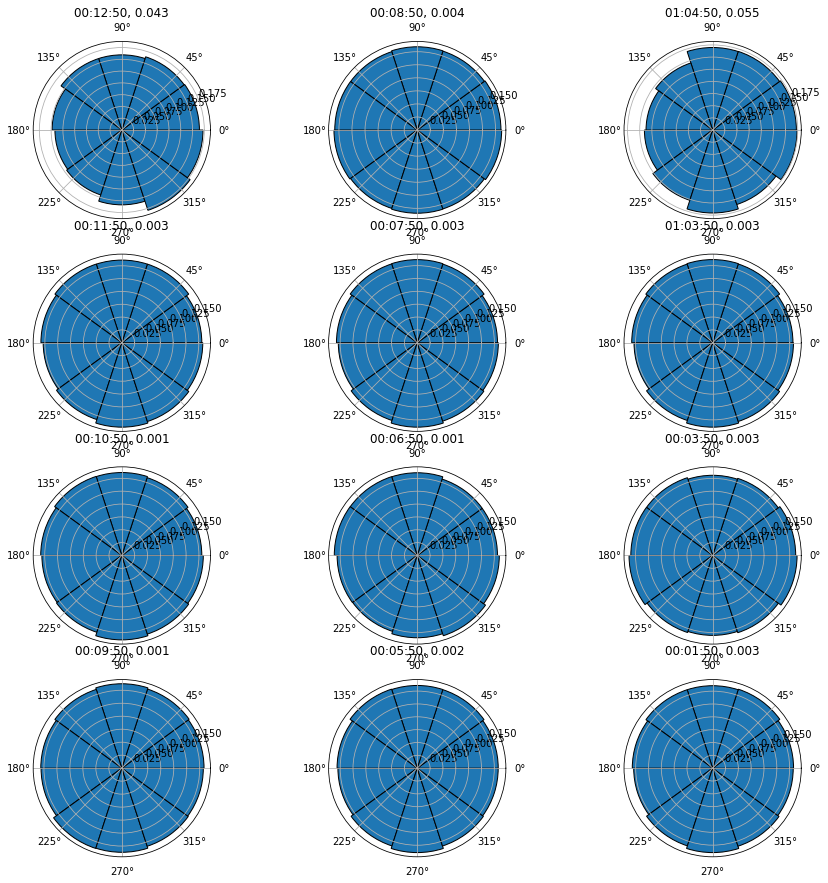

In [668]:
%matplotlib inline
def wrap(phases):
    return (phases + np.pi) % (2 * np.pi) - np.pi

def get_plv(phases):
    plv = (np.exp(1j*phases)).mean()
    return plv

def circ_detrend(phases): 
    # uses Euler's formula to get angle's vector, then get mean angle
    # plv = np.abs(np.sum(complex_phase_diff)/ len(phases))
    # plv= np.abs(np.sum(np.exp(1j*phases))) / len(phases)
    plv = get_plv(phases)
    mean = np.angle(plv)
    return plv, wrap(phases-mean) 


## Make an array of PLVs for each epoch and channel. Maybe not so useful right now. 
# the thing with this is that the random ITI - phase shifts are not incorporated into the epochs. 
plv_arr = np.zeros(shape=[num_primary_channels, num_trials])
for ch in range(num_primary_channels):
    for i in range(num_trials): 
        opm_angle = np.angle(hilbert(epo_opm_f10[ch, i, :]), deg=False)
        data = wrap(epo_diode_phase[i] - opm_angle)
        plv_arr[ch, i] = np.abs(get_plv(data))
    
print("PLV for channel 9 in all epochs: ", plv_arr[9, :])



## check PLV in the whole time-series, which includes ITI 

# segment to start of experiment and end of experiment time 
raw_arr = raw_fil_10[:][0][:, start_marker_index:end_marker_index]
adc_diode_square_cut = adc_diode_square[start_marker_index:end_marker_index]
adc_diode_phase_cut = np.angle(hilbert(adc_diode_square_cut), deg=False)

# angle = np.angle(hilbert(epo_opm_f10[ch, i, :]), deg=False)
# data = wrap(adc_diode_phase_cut - raw_arr)
# plv_arr[ch, i] = np.abs(get_plv(data))

plt.figure(figsize=(15,15))
## for each channel
for i in range(raw_arr.shape[0]): 

    opm_angle = np.angle(hilbert(raw_arr[i]), deg=False)
    data = wrap(adc_diode_phase_cut-opm_angle)

    plt.subplot(4,3,i+1, polar=True)
    # ax.get_yaxis().set_visible(False)
    plv, detrend_data = circ_detrend(data)

    plt.hist(detrend_data,density=True,edgecolor='black')
    plt.title('%s, %.3f' % (raw.ch_names[i], np.abs(plv)))





No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 39 - 41 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 39.00
- Lower transition bandwidth: 9.75 Hz (-6 dB cutoff frequency: 34.12 Hz)
- Upper passband edge: 41.00 Hz
- Upper transition bandwidth: 10.25 Hz (-6 dB cutoff frequency: 46.12 Hz)
- Filter length: 339 samples (0.339 sec)

No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 19 - 21 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin)

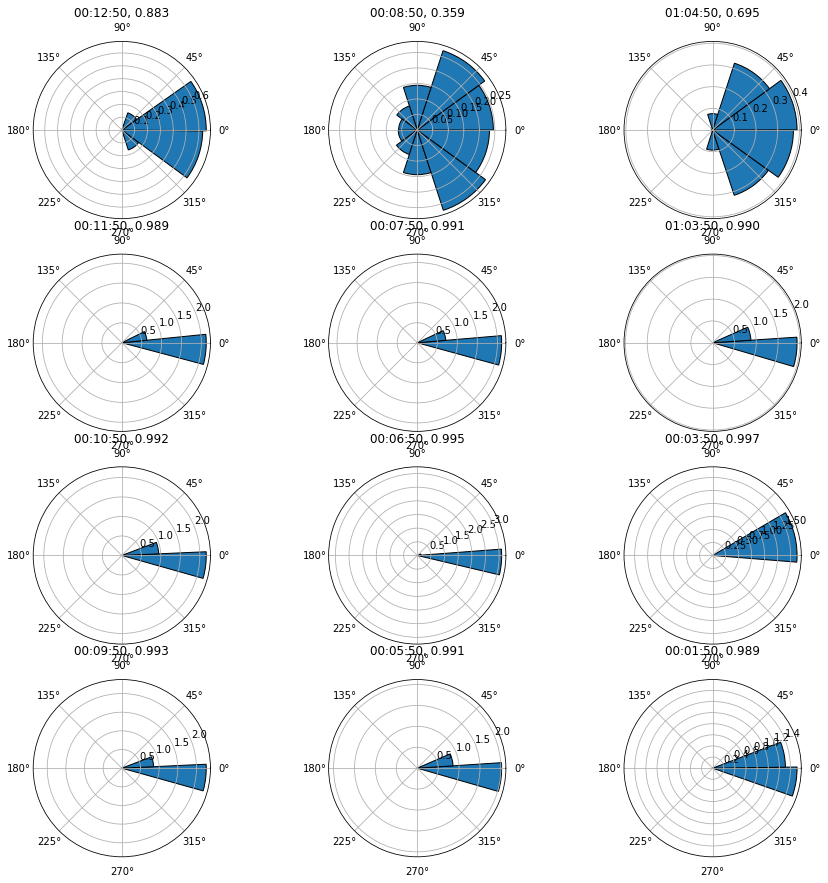

In [669]:




# plt.plot(raw_tacs[:][0][0,:50000])
angle1 = np.angle(raw_tacs.copy().filter(39,41, picks=tACS_channel).apply_hilbert(envelope=True, picks=tACS_channel).filter(4,6, picks=tACS_channel).apply_hilbert(envelope=False, picks=tACS_channel)[:][0][0,start_marker_index:end_marker_index])


plt.figure(figsize=(15,15))
## for each channel
for i in range(raw_arr.shape[0]): 

    opm_angle = np.angle(hilbert(raw_arr[i]), deg=False)
    data = wrap(angle1-opm_angle)

    plt.subplot(4,3,i+1, polar=True)
    # ax.get_yaxis().set_visible(False)
    plv, detrend_data = circ_detrend(data)

    plt.hist(detrend_data,density=True,edgecolor='black')
    plt.title('%s, %.3f' % (raw.ch_names[i], np.abs(plv)))